# Data driven prediction of battery cycle life before capacity degradation

Paper:

[Severson, K.A., Attia, P.M., Jin, N. et al. Data-driven prediction of battery cycle life before capacity degradation. Nat Energy 4, 383–391 (2019)](https://www.nature.com/articles/s41560-019-0356-8)


Data:

[Experimental Data Platform (matr.io))](https://data.matr.io/1/projects/5c48dd2bc625d700019f3204)


## Structure of this Notebook

* Test with one data file (1 cell) and look at data structure
* Extract summary data (per cycle) and reproduce figures based on that
* Extract intercycle data and reproduce figures based on that
    - Only a portion of the cells can be included because of computational expense
* Reproduce machine learning models
    - Variance model
    - Discharge model
    - Full model

## Import packages and modules

In [1]:
import pathlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os, random
import numpy as np
import statistics

## Try with a test file

In [2]:
# edit this if you dont have the data in a subfolder called data
testfile = pathlib.Path("/Volumes/SanDisk/FastCharge") / "FastCharge_000007_CH39_structure.json"
testfile.is_file()

True

In [3]:
df = pd.read_json(testfile)

In [12]:
df.columns

Index(['@module', '@class', 'barcode', 'protocol', 'channel_id', 'summary',
       'cycles_interpolated', 'diagnostic_summary', 'diagnostic_interpolated',
       '@version'],
      dtype='object')

In [5]:
df.index

Index(['cycle_index', 'discharge_capacity', 'charge_capacity',
       'discharge_energy', 'charge_energy', 'dc_internal_resistance',
       'temperature_maximum', 'temperature_average', 'temperature_minimum',
       'date_time_iso', 'energy_efficiency', 'charge_throughput',
       'energy_throughput', 'charge_duration', 'time_temperature_integrated',
       'paused', 'voltage', 'current', 'temperature', 'internal_resistance',
       'step_type'],
      dtype='object')

In [6]:
df.head(20)

,@module,@class,barcode,protocol,channel_id,summary,cycles_interpolated,diagnostic_summary,diagnostic_interpolated,@version
cycle_index,beep.structure,ProcessedCyclerRun,el150800737320,2018-04-12_batch8\20180412-5_9C_15per_4_6C_new...,38,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020.10.19.20-8667111
discharge_capacity,beep.structure,ProcessedCyclerRun,el150800737320,2018-04-12_batch8\20180412-5_9C_15per_4_6C_new...,38,"[1.5537410999999999, 1.0652004, 1.0663688, 1.0...","[1.239493058590234, 1.356596500246578, 1.47369...",NaN,NaN,2020.10.19.20-8667111
charge_capacity,beep.structure,ProcessedCyclerRun,el150800737320,2018-04-12_batch8\20180412-5_9C_15per_4_6C_new...,38,"[1.063142499999999, 1.064750399999999, 1.06594...","[0.811714026408144, 0.933594370952411, 1.05547...",NaN,NaN,2020.10.19.20-8667111
discharge_energy,beep.structure,ProcessedCyclerRun,el150800737320,2018-04-12_batch8\20180412-5_9C_15per_4_6C_new...,38,"[4.7624459, 3.2459061, 3.2504842, 3.2541139, 3...",NaN,NaN,NaN,2020.10.19.20-8667111
charge_energy,beep.structure,ProcessedCyclerRun,el150800737320,2018-04-12_batch8\20180412-5_9C_15per_4_6C_new...,38,"[3.7076066, 3.6959732, 3.6983836, 3.7004894999...",NaN,NaN,NaN,2020.10.19.20-8667111
dc_internal_resistance,beep.structure,ProcessedCyclerRun,el150800737320,2018-04-12_batch8\20180412-5_9C_15per_4_6C_new...,38,"[0.015025828965008, 0.014992444775998, 0.01496...",NaN,NaN,NaN,2020.10.19.20-8667111
temperature_maximum,beep.structure,ProcessedCyclerRun,el150800737320,2018-04-12_batch8\20180412-5_9C_15per_4_6C_new...,38,"[32.24843978881836, 31.780742645263672, 31.723...",NaN,NaN,NaN,2020.10.19.20-8667111
temperature_average,beep.structure,ProcessedCyclerRun,el150800737320,2018-04-12_batch8\20180412-5_9C_15per_4_6C_new...,38,"[30.910825729370117, 31.250967025756836, 31.24...",NaN,NaN,NaN,2020.10.19.20-8667111
temperature_minimum,beep.structure,ProcessedCyclerRun,el150800737320,2018-04-12_batch8\20180412-5_9C_15per_4_6C_new...,38,"[22.150121688842773, 30.74786376953125, 30.744...",NaN,NaN,NaN,2020.10.19.20-8667111
date_time_iso,beep.structure,ProcessedCyclerRun,el150800737320,2018-04-12_batch8\20180412-5_9C_15per_4_6C_new...,38,"[2018-04-13T01:27:28+00:00, 2018-04-14T06:21:5...",NaN,NaN,NaN,2020.10.19.20-8667111


## Function to extract a specific column
- Using the function made by Jan-Petter

In [19]:
def select_dataset(df, column):
    # tested for summary column 
    
    if not isinstance(column, (list, tuple)):
        column = [column]
        
    s = df.loc[:, column]
    print(f"Shape of selected packed dataset: {s.shape}")
    
    s = s.dropna()
    print(f"Shape of selected packed dataset without NaNs: {s.shape}")
    if s.empty:
        print("Non values found")
        return
    
    s = s.T.apply(pd.Series.explode).set_index("cycle_index")
    print(f"Shape of selected unpacked dataset: {s.shape}")

    return s

## Create a list containing the summary data (per cycle) for each cell

In [9]:
%%time

directory = r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\MLData"
summary = []

# iterate over files in that directory
i = 0
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        print(f)
        # Make dataframe of file and add the summary column to list
        df = pd.read_json(f)
        summary.append(select_dataset(df, 'summary'))
        
        print(i)
        i+=1

C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\MLData\FastCharge_000000_CH19_structure.json
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (491, 15)
0
C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\MLData\FastCharge_000001_CH16_structure.json
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (667, 15)
1
C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\MLData\FastCharge_000001_CH30_structure.json
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (773, 15)
2
C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\MLData\FastCharge_000001_CH38_structure.json
Shape of selected packed dataset: (21, 1)
Shape of selected p

Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (526, 15)
30
C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\MLData\FastCharge_000009_CH7_structure.json
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (489, 15)
31
C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\MLData\FastCharge_000009_CH8_structure.json
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (500, 15)
32
C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\MLData\FastCharge_000010_CH44_structure.json
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (489, 15)
33
C:\Users\ife12216\OneDrive - Institutt f

Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (1391, 15)
61
C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\MLData\FastCharge_000017_CH6_structure.json
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (1643, 15)
62
C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\MLData\FastCharge_000017_CH9_structure.json
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (1802, 15)
63
C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\MLData\FastCharge_000018_CH18_structure.json
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (789, 15)
64
C:\Users\ife12216\OneDrive - Institut

Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (918, 15)
92
C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\MLData\FastCharge_000040_CH32_structure.json
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (521, 15)
93
C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\MLData\FastCharge_000041_CH10_structure.json
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (172, 15)
94
C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\MLData\FastCharge_000042_CH36_structure.json
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (488, 15)
95
C:\Users\ife12216\OneDrive - Institutt

Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (494, 15)
123
C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\MLData\FastCharge_000062_CH47_structure.json
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (451, 15)
124
C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\MLData\FastCharge_000063_CH5_structure.json
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (1227, 15)
125
C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\MLData\FastCharge_000063_CH6_structure.json
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (1227, 15)
126
C:\Users\ife12216\OneDrive - Insti

#### Overview of data in summary

In [20]:
summary[10].head(3)

,discharge_capacity,charge_capacity,discharge_energy,charge_energy,dc_internal_resistance,temperature_maximum,temperature_average,temperature_minimum,date_time_iso,energy_efficiency,charge_throughput,energy_throughput,charge_duration,time_temperature_integrated,paused
cycle_index,,,,,,,,,,,,,,,
0,1.559709,1.067178,4.779114,3.722037,0.016217,37.493538,31.868103,22.183815,2018-04-13T01:27:28+00:00,1.284005,1.067178,3.722037,101632.0,None,0
1,1.06916,1.068725,3.257659,3.709188,0.01601,37.5312,34.545357,31.361633,2018-04-14T06:19:44+00:00,0.878267,2.135903,7.431225,640.0,1611.899363,0
2,1.070147,1.069783,3.261968,3.711117,0.015988,37.512012,34.551731,31.414553,2018-04-14T07:06:40+00:00,0.878972,3.205686,11.142343,640.0,1611.78905,0


## Create a list containing the intercycle data for 30 cells

In [21]:
cycles_interpolated = []
summary_selected = []
rand_arr = np.random.randint(0,139,size=30)
i = 0

for filename in os.listdir(directory)[30:60]:
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        print(f)
        print(i)
        i+=1
        
        # Make dataframe of file and add the cycles_interpolated column to list
        df = pd.read_json(f)
        cycles_interpolated.append(select_dataset(df, 'cycles_interpolated'))
        summary_selected.append(select_dataset(df, 'summary'))

C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\MLData\FastCharge_000009_CH4_structure.json
0
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (8, 1)
Shape of selected unpacked dataset: (1052000, 7)
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (526, 15)
C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\MLData\FastCharge_000009_CH7_structure.json
1
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (8, 1)
Shape of selected unpacked dataset: (978000, 7)
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (489, 15)
C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\MLData\FastCharge_000009_CH8_structure.json
2
Shape of selected packed dataset: (21, 1)
Sh

Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (8, 1)
Shape of selected unpacked dataset: (1634000, 7)
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (817, 15)
C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\MLData\FastCharge_000015_CH28_structure.json
21
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (8, 1)
Shape of selected unpacked dataset: (2294000, 7)
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (16, 1)
Shape of selected unpacked dataset: (1147, 15)
C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\MLData\FastCharge_000015_CH36_structure.json
22
Shape of selected packed dataset: (21, 1)
Shape of selected packed dataset without NaNs: (8, 1)
Shape of selected unpacked dataset: (2058000, 7)
Shape of selected pa

#### Overview of data in cycles_interpolated

In [22]:
cycles_interpolated[10].head(3)

,discharge_capacity,charge_capacity,voltage,current,internal_resistance,temperature,step_type
cycle_index,,,,,,,
0,0.667727,0.211074,2.8,-1.758599,0.015244,32.956676,discharge
0,0.592003,0.132816,2.800701,-1.514386,0.015244,32.576221,discharge
0,0.516279,0.054558,2.801401,-1.270173,0.015244,32.195766,discharge


## Make colormap for sorting all cells by cycle life

In [23]:
from matplotlib.colors import LinearSegmentedColormap

cl_all = []
for cell in summary:
    cl_all.append(cell.index[-1])
    
cl_all = np.array(cl_all)
cl_all = np.sort(cl_all)[::-1]
cl_all_norm = minmax_scale(cl_all)

colormap = mpl.cm.ScalarMappable(cmap='RdBu_r')
colors_all = colormap.to_rgba(cl_all_norm)

## Make colormap for sorting the selected 30 cells by cycle life

In [24]:
cl_30 = []
for cell in cycles_interpolated:
    cl_30.append(cell.index[-1])
    
cl_30 = np.array(cl_30)
cl_30 = np.sort(cl_30)[::-1]
cl_30_norm = minmax_scale(cl_30)

colormap = mpl.cm.ScalarMappable(cmap='RdBu_r')
colors_30 = colormap.to_rgba(cl_30_norm)

# Reproduce figures from Severson et al

### Per cycle based figures (using all cells)

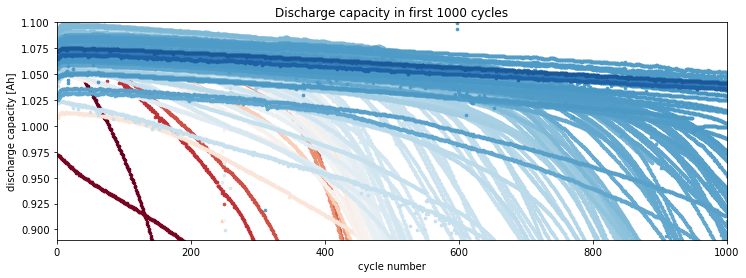

In [25]:
# FIG 1a

# Sort cells according to cycle life
summary = sorted(summary, key=lambda x:x.index[-1])
Qd_ratios = []

# Plot
fig, ax = plt.subplots(figsize=(12,4))
i = 0
for cell in summary:
    if cell.index[-1] > 100:
        Qd = cell['discharge_capacity'][1:-1]
        cycles = cell.index[1:-1]
        ax.scatter(cycles, Qd, s=7, color=colors_all[i])
        ax.set_xlabel('cycle number')
        ax.set_ylabel('discharge capacity [Ah]')
        ax.set_xlim(0,1000)
        ax.set_ylim(0.89,1.1)
        ax.set_title("Discharge capacity in first 1000 cycles")

        Qd_ratios.append(float(cell['discharge_capacity'][99]/cell['discharge_capacity'][1]))

        i += 1

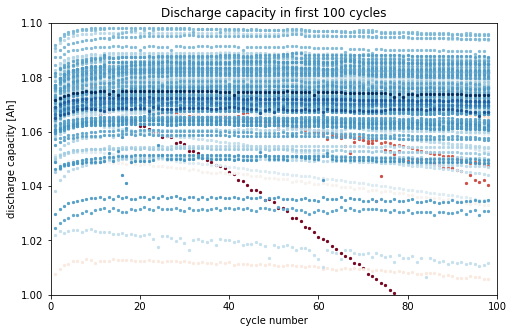

In [26]:
# FIG 1b

fig, ax = plt.subplots(figsize=(8,5))
i = 0
for cell in summary:
    Qd100 = cell['discharge_capacity'][1:99]
    cycles = cell.index[1:99]
    ax.scatter(cycles, Qd100, s=5, color=colors_all[i])
    ax.set_xlabel('cycle number')
    ax.set_ylabel('discharge capacity [Ah]')
    ax.set_xlim(0,100)
    ax.set_ylim(1,1.1)
    ax.set_title("Discharge capacity in first 100 cycles")
    
    i += 1

Text(0.5, 1.0, 'Ratio of discharge capacity between cycle 100 and 2')

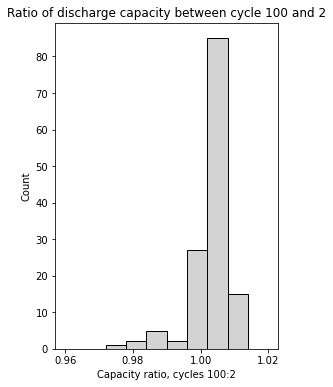

In [27]:
# FIG 1c
fig, ax = plt.subplots(figsize=(4,6))
ax.hist(Qd_ratios, range=(0.96,1.02), color='lightgrey', edgecolor='black')
ax.set_xticks([0.96, 0.98, 1.00, 1.02])
ax.set_xlabel('Capacity ratio, cycles 100:2')
ax.set_ylabel('Count', rotation=('vertical'))
ax.set_title('Ratio of discharge capacity between cycle 100 and 2')

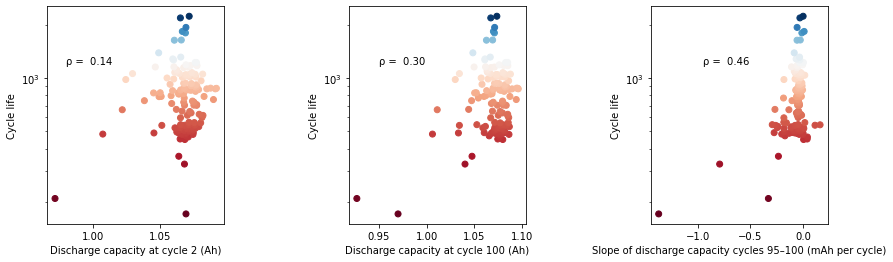

In [28]:
# FIG 1d-f

fig, ax = plt.subplots(ncols=3, figsize=(14,4))

Qd_cycle2 = []
Qd_cycle100 = []
Qd_cycle_95_100 = []
cl = []

for cell in summary:
    if cell.index[-1] > 100:
        cl.append(cell.index[-1])
        Qd_cycle2.append(float(cell['discharge_capacity'][1]))
        Qd_cycle100.append(float(cell['discharge_capacity'][99]))
        Qd_cycle_95_100.append(float(1000*(cell['discharge_capacity'][99] - cell['discharge_capacity'][94])/5))

    
# Correlation coefficients
corrcoef2 = np.corrcoef(np.log(cl), Qd_cycle2)
corrcoef100 = np.corrcoef(np.log(cl), Qd_cycle100)
corrcoef_95_100 = np.corrcoef(np.log(cl), Qd_cycle_95_100)


# Scatter plots
ax[0].scatter(Qd_cycle2, cl, c=cl, cmap='RdBu')
ax[0].set_xlabel('Discharge capacity at cycle 2 (Ah)')
ax[0].set_ylabel('Cycle life', rotation='vertical')
ax[0].set_yscale('log')
ax[0].text(0.98, 1200, f"\u03C1 =  {corrcoef2[1,0]:.2f}")

ax[1].scatter(Qd_cycle100, cl, c=cl, cmap='RdBu')
ax[1].set_xlabel('Discharge capacity at cycle 100 (Ah)')
ax[1].set_ylabel('Cycle life', rotation='vertical')
ax[1].set_yscale('log')
ax[1].text(0.95, 1200, f"\u03C1 =  {corrcoef100[1,0]:.2f}")

ax[2].scatter(Qd_cycle_95_100, cl, c=cl, cmap='RdBu')
ax[2].set_xlabel('Slope of discharge capacity cycles 95–100 (mAh per cycle)')
ax[2].set_ylabel('Cycle life', rotation='vertical')
ax[2].set_yscale('log')
ax[2].text(-0.95, 1200, f"\u03C1 =  {corrcoef_95_100[1,0]:.2f}")

#plt.title('Cycle life as function of various discharge capacity properties')
plt.subplots_adjust(wspace=0.7)

### Cycles interpolated based figures (using 30 cells)
- Cycles interpolated is computationally expensive, so only a portion of the cells can be included
- Solution: Make figures and models with smaller dataset first, then get access to UiO computer remotely to do the modeling for the full set.

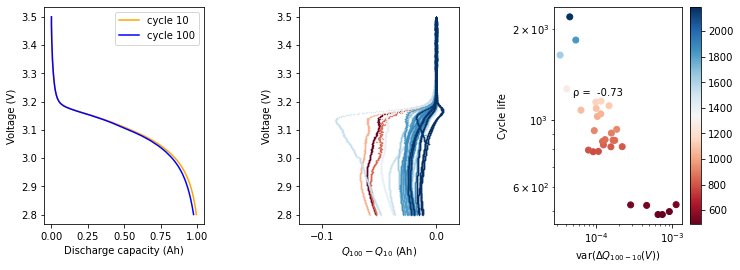

In [29]:
# FIG 2a
# Note 1: Cells are cycled from 2.0 V to 3.6 V, but the data only shows the range 2.8 V to 3.6 V.
# Note 2: Cells have 1.1 Ah nominall capacity, but the data only shows charging from 0 to 1. Normalised?


repr_cell = cycles_interpolated[11]
repr_cell_discharge = repr_cell.loc[repr_cell['step_type'] == 'discharge', 'discharge_capacity']
repr_cell_voltage = repr_cell.loc[repr_cell['step_type'] == 'discharge', 'voltage']

alt_voltage = np.linspace(2,3.6,1000)

s100_discharge = repr_cell_discharge.loc[99]
s10_discharge = repr_cell_discharge.loc[9]

s100_voltage = repr_cell_voltage.loc[99]
s10_voltage = repr_cell_voltage.loc[9]

# Figure for plot
fig, ax = plt.subplots(ncols=3, figsize=(12,4))

# Plot for 100th and 10th cycle
ax[0].plot(s10_discharge, s10_voltage, color='orange', label='cycle 10')
ax[0].plot(s100_discharge, s100_voltage, color='blue', label='cycle 100')
ax[0].set_xlabel('Discharge capacity (Ah)')
ax[0].set_ylabel('Voltage (V)', rotation='vertical')
ax[0].legend()

# Sort cells by cycle life
cycles_interpolated_sorted = sorted(cycles_interpolated, key=lambda x:x.index[-1])
summary_selected_sorted = sorted(summary_selected, key=lambda x:x.index[-1])
cycle_lives = []
V10 = []
var100_10 = []
i = 0

for cell in cycles_interpolated_sorted:
    
    cycle_lives.append(float(cell.index[-1]))
    
    # Qd and voltage for each cell
    Qd = cell.loc[cell['step_type'] == 'discharge' , 'discharge_capacity'] 
    voltage = cell.loc[cell['step_type'] == 'discharge' , 'voltage'] 
    
    # interpolated voltage range for a cycle (chose cycle 10, same for all)
    V10 = voltage[9]
    
    # Qd100-10 and variance
    Qd100_10 = Qd[99].values - Qd[9].values
    var100_10.append(float(statistics.variance(Qd100_10)))
    

    # Qd100-10 as function of voltage
    ax[1].scatter(Qd100_10, V10, s=0.1, color=colors_30[i])
    ax[1].set_xlim(-0.12,0.02)
    ax[1].set_xticks([-0.1, 0])
    ax[1].set_xlabel('$Q_{100} - Q_{10}$ (Ah)')
    ax[1].set_ylabel('Voltage (V)', rotation='vertical')

    i += 1

# Correlation coefficient
corr_variance = np.corrcoef(np.log10(cycle_lives), var100_10)

# var(Qd100-10) as function of cycle life    
im = ax[2].scatter(var100_10, cycle_lives, c=cycle_lives, cmap='RdBu')
fig.colorbar(im, ax=ax[2])
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlabel('var($\u0394Q_{100-10}(V)$)')
ax[2].set_ylabel('Cycle life')
ax[2].text(0.00005, 1200, f"\u03C1 =  {corr_variance[1,0]:.2f}")

plt.subplots_adjust(wspace=0.6)

# ML models

There are three models in the paper, with increasing amount of available features. The features can be split into three categories.

Features based on $\Delta Q_{100-10}(V)$
- f1: min$(\Delta Q_{100-10}(V))$
- f2: mean$(\Delta Q_{100-10}(V))$
- f3: var$(\Delta Q_{100-10}(V))$
- f4: skewness$(\Delta Q_{100-10}(V))$
- f5: kurtosis$(\Delta Q_{100-10}(V))$

Features based on the discharge capacity fade curves
- f6: Slope of the linear fit to the capacity fade curve, cycles 2 to 100
- f7: Intercept of the linear fit to capacity fade curve, cycles 2 to 100
- f8: Slope of the linear fit to the capacity fade curve, cycles 91 to 100
- f9: Intercept of the linear fit to capacity fade curve, cycles 91 to 100
- f10: Discharge capacity, cycle 2
- f11: Difference between max discharge capacity and cycle 2
- f12: Discharge capacity, cycle 100

Other features
- f13: Average charge time, first 5 cycles
- f14: Maximum temperature, cycles 2 to 100
- f15: Minimum temperature, cycles 2 to 100
- f16: Integral of temperature over time, cycles 2 to 100
- f17: Internal resistance, cycle 2
- f18: Minimum internal resistance, cycles 2 to 100
- f19: Internal resistance, difference between cycle 100 and cycle 2

One additional feature from the paper, the discharge capacity at 2 V, is not included here. The reason is that the voltage in this dataset only ranges from 3.6 to 2.8 V as mentioned earlier in the Notebook.

In [30]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import skew, kurtosis

#### Error functions

In [31]:
def get_errors(y_train, y_test, y_train_pred, y_test_pred):
    mse_cycles_train = mean_squared_error(np.power(10, y_train), np.power(10, y_train_pred), squared=False)
    mse_cycles_test = mean_squared_error(np.power(10, y_test), np.power(10, y_test_pred), squared=False)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
    
    return mse_cycles_train, mse_cycles_test, mape_train, mape_test

#### Feature generation

In [32]:
n_features = 19
n_targets = len(cycles_interpolated)

# Prediction target
y = np.zeros(n_targets)

# Design matrix
X = np.zeros((n_targets,n_features))

# Intercycle features f1-f5
for i in range(len(cycles_interpolated_sorted)):
    Qd = cycles_interpolated[i].loc[cycles_interpolated[i]['step_type'] == 'discharge' , 'discharge_capacity']
    Qd100_10 = Qd[99].values - Qd[9].values
    
    X[i,0] = np.log10(abs(np.amin(Qd100_10)))
    X[i,1] = np.log10(abs(np.mean(Qd100_10)))
    X[i,2] = np.log10(float(np.var(Qd100_10)))
    X[i,3] = np.log10(abs(skew(Qd100_10)))
    X[i,4] = np.log10(abs(kurtosis(Qd100_10)))
    
# Per cycle features
for i in range(len(summary_selected_sorted)):
    y[i] = np.log10(summary_selected[i].index[-1])
    
    slope100_2 = float((summary_selected[i]['discharge_capacity'][99] - summary_selected[i]['discharge_capacity'][1])/98) #dQd / dcycle
    slope100_91 = float((summary_selected[i]['discharge_capacity'][99] - summary_selected[i]['discharge_capacity'][1])/9)
    intercept100_2 = summary_selected[i]['discharge_capacity'][9] - slope100_2*10 # b = y-mx
    intercept100_91 = summary_selected[i]['discharge_capacity'][9] - slope100_91*10 # b = y-mx
    diff = np.amax(summary_selected[i]['discharge_capacity'][1:-1] - summary_selected[i]['discharge_capacity'][1])
    
    
    X[i,5] = slope100_2
    X[i,6] = intercept100_2
    X[i,7] = slope100_91
    X[i,8] = intercept100_91
    X[i,9] = summary_selected[i]['discharge_capacity'][1]
    X[i,10] = diff
    X[i,11] = summary_selected[i]['discharge_capacity'][99]
    
    X[i,12] = np.mean(summary_selected[i]['charge_duration'][1:6])
    X[i,13] = np.amax(summary_selected[i]['temperature_maximum'][1:99])
    X[i,14] = np.amin(summary_selected[i]['temperature_minimum'][1:99])
    X[i,15] = np.mean(summary_selected[i]['time_temperature_integrated'][1:99])
    X[i,16] = summary_selected[i]['dc_internal_resistance'][1]
    X[i,17] = np.amin(summary_selected[i]['dc_internal_resistance'][1:99])
    X[i,18] = summary_selected[i]['dc_internal_resistance'][99] - summary_selected[i]['dc_internal_resistance'][1]

## First model: 'Variance' model

In [33]:
X_var = X[:,2].reshape(-1,1)

scaler = StandardScaler()
X_var_scaled = scaler.fit_transform(X_var)

X_train, X_test, y_train_var, y_test_var = train_test_split(X_var_scaled, y, test_size=0.33, random_state=22)

var_model = ElasticNetCV(cv=10, random_state=22)
var_model.fit(X_train, y_train_var)
var_pred_train = var_model.predict(X_train)
var_pred_test = var_model.predict(X_test)

print('RMSE Cycles train: %.4f, RMSE Cycles test: %.4f, MAPE train: %.4f, MAPE test: %.4f'\
      %(get_errors(y_train_var,y_test_var,var_pred_train,var_pred_test)))

# Comment about results: 
# Without using random_state, the results can vary by 100 cycles or more.
# This is most likely because of the small sample size of 30 cells.

RMSE Cycles train: 223.3834, RMSE Cycles test: 227.1372, MAPE train: 0.0205, MAPE test: 0.0207


## Second model: 'Discharge' model
Features f1-f13 are used as input to this model

In [34]:
X_discharge = X[:,0:12] #Shape (30,12)
X_discharge_scaled = scaler.fit_transform(X_discharge)


X_train, X_test, y_train_discharge, y_test_discharge = train_test_split(X_discharge_scaled, y, test_size=0.33, random_state=22)



discharge_model = ElasticNetCV(cv=10, random_state=22, max_iter=10000, tol=0.0001)
discharge_model.fit(X_train, y_train_discharge)
discharge_pred_train = discharge_model.predict(X_train)
discharge_pred_test = discharge_model.predict(X_test)

print('RMSE Cycles train: %.4f, RMSE Cycles test: %.4f, MAPE train: %.4f, MAPE test: %.4f'\
      %(get_errors(y_train_discharge,y_test_discharge,discharge_pred_train,discharge_pred_test)))

RMSE Cycles train: 155.5360, RMSE Cycles test: 226.1706, MAPE train: 0.0129, MAPE test: 0.0211


## Third model: 'Full' model

Features f1-f19 are used as input to this model

In [35]:
X_full = X # Shape (30,19)
X_full_scaled = scaler.fit_transform(X_full)

X_train, X_test, y_train_full, y_test_full = train_test_split(X_full_scaled, y, test_size=0.33, random_state=22)

full_model = ElasticNetCV(cv=10, random_state=22, max_iter=10000, tol=0.0001)
full_model.fit(X_train, y_train_full)
full_pred_train = full_model.predict(X_train)
full_pred_test = full_model.predict(X_test)

print('RMSE Cycles train: %.4f, RMSE Cycles test: %.4f, MAPE train: %.4f, MAPE test: %.4f'\
      %(get_errors(y_train_full,y_test_full,full_pred_train,full_pred_test)))

RMSE Cycles train: 91.9525, RMSE Cycles test: 352.0138, MAPE train: 0.0061, MAPE test: 0.0311


### Plots showing linear relationship between some features and cycle life

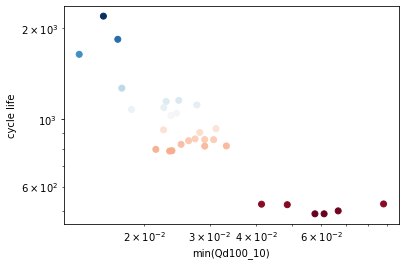

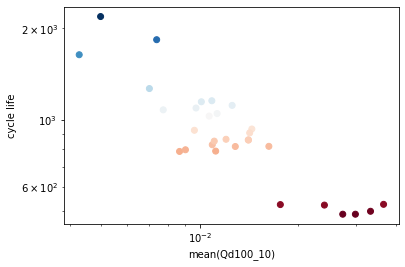

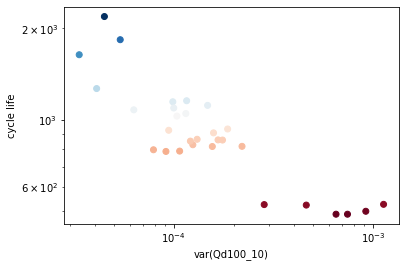

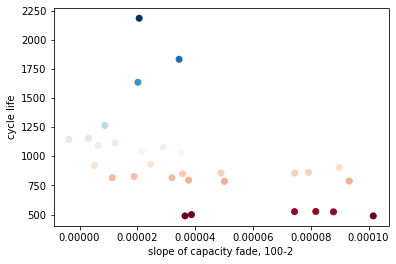

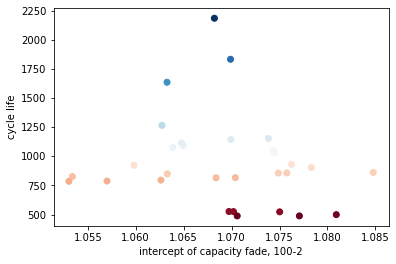

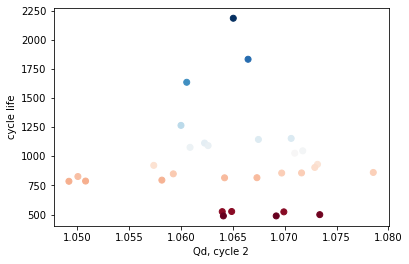

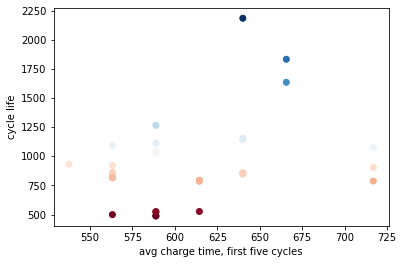

In [36]:
plt.scatter(np.power(10,X[:,0]), np.power(10,y), c=y, cmap='RdBu')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('min(Qd100_10)')
plt.ylabel('cycle life')
plt.show()

plt.scatter(np.power(10,X[:,1]), np.power(10,y), c=y, cmap='RdBu')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('mean(Qd100_10)')
plt.ylabel('cycle life')
plt.show()

plt.scatter(np.power(10,X[:,2]), np.power(10,y), c=y, cmap='RdBu')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('var(Qd100_10)')
plt.ylabel('cycle life')
plt.show()

plt.scatter(X[:,5], np.power(10,y), c=y, cmap='RdBu')
#plt.yscale('log')
plt.xlabel('slope of capacity fade, 100-2')
plt.ylabel('cycle life')
plt.show()

plt.scatter(X[:,6], np.power(10,y), c=y, cmap='RdBu')
#plt.yscale('log')
plt.xlabel('intercept of capacity fade, 100-2')
plt.ylabel('cycle life')
plt.show()

plt.scatter(X[:,9], np.power(10,y), c=y, cmap='RdBu')
#plt.yscale('log')
plt.xlabel('Qd, cycle 2')
plt.ylabel('cycle life')
plt.show()

plt.scatter(X[:,12], np.power(10,y), c=y, cmap='RdBu')
#plt.yscale('log')
plt.xlabel('avg charge time, first five cycles')
plt.ylabel('cycle life')
plt.show()

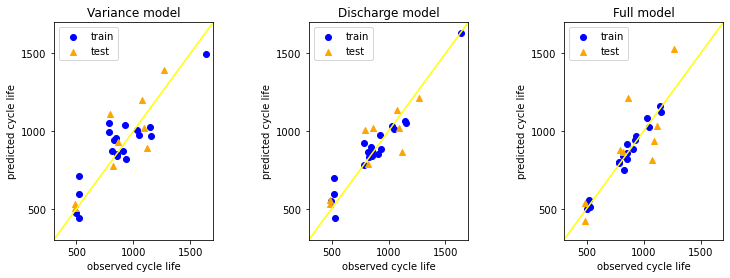

In [37]:
fig, ax = plt.subplots(ncols=3, figsize=(12,4))

x_line = np.linspace(0,1700)
y_line = np.linspace(0,1700)

ax[0].scatter(np.power(10,y_train_var), np.power(10,var_pred_train), color='blue', label='train')
ax[0].scatter(np.power(10,y_test_var), np.power(10,var_pred_test), color='orange', marker='^', label='test')
ax[0].plot(x_line,y_line, color='yellow')
ax[0].set_xlim(300,1700)
ax[0].set_ylim(300,1700)
ax[0].set_xticks([500,1000,1500])
ax[0].set_yticks([500,1000,1500])
ax[0].set_xlabel('observed cycle life')
ax[0].set_ylabel('predicted cycle life')
ax[0].legend()
ax[0].set_title('Variance model')


ax[1].scatter(np.power(10,y_train_discharge), np.power(10,discharge_pred_train), color='blue', label='train')
ax[1].scatter(np.power(10,y_test_discharge), np.power(10,discharge_pred_test), color='orange', marker='^', label='test')
ax[1].plot(x_line,y_line, color='yellow')
ax[1].set_xlim(300,1700)
ax[1].set_ylim(300,1700)
ax[1].set_xticks([500,1000,1500])
ax[1].set_yticks([500,1000,1500])
ax[1].set_xlabel('observed cycle life')
ax[1].set_ylabel('predicted cycle life')
ax[1].legend()
ax[1].set_title('Discharge model')


ax[2].scatter(np.power(10,y_train_full), np.power(10,full_pred_train), color='blue', label='train')
ax[2].scatter(np.power(10,y_test_full), np.power(10,full_pred_test), color='orange', marker='^', label='test')
ax[2].plot(x_line,y_line, color='yellow')
ax[2].set_xlim(300,1700)
ax[2].set_ylim(300,1700)
ax[2].set_xticks([500,1000,1500])
ax[2].set_yticks([500,1000,1500])
ax[2].set_xlabel('observed cycle life')
ax[2].set_ylabel('predicted cycle life')
ax[2].legend()
ax[2].set_title('Full model')

plt.subplots_adjust(wspace=0.6)
plt.show()

Models performed significantly better after scaling

### manual calculation of variance for control 

In [38]:
print(np.power(10,X[0,2])) # Variance for first cell from np.var()

# Variance for first cell manually calculated
Qd = cycles_interpolated[0].loc[cycles_interpolated[0]['step_type'] == 'discharge' , 'discharge_capacity']
Qd100_10 = Qd[99].values - Qd[9].values
avg = np.mean(Qd100_10)
variance = float(sum((Qd100_10 - avg)**2)/len(Qd100_10))

print(variance)

0.00028431282957641255
0.00028431282957641245
